In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:80% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:24pt;}
div.text_cell_render.rendered_html{font-size:20pt;}
div.text_cell_render ul li{font-size:22pt; line-height:30px;}
div.output {font-size:24pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:24pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:24pt;padding:5px;}
table.dataframe{font-size:24px;}
</style>
"""))

In [2]:
import pandas as pd
import numpy as np
import sys # 최대 정수
from tensorflow.keras.utils import to_categorical # to_categorical() : 분류분석시 y데이터 원핫인코딩
from tensorflow.keras.models import Sequential # 모델 생성
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split # 데이터 분리

# 이진분류(로지스틱 회귀분석)
- 1. 데이터셋 생성 & 전처리
    * 엑셀 -> 데이터프레임 -> ?처리(결측치로 전환하여 결측치처리) -> X, y분리
      -> X변수의 scale 조정 -> train_test_split()이용하여 학습셋과 테스트셋분리
- 2. 모델생성(입력13, 출력1) & 학습과정 설정 & 학습
- 3. 모델평가(그래프, 평가, 혼동행렬==교차표)
- 4. 모델 사용

In [3]:
'''
age 나이 (세)
sex 성별
    1 : 남성
    0 : 여성
cp (chest pain type) 가슴 통증(흉통) 타입
    1 : typical angina (전형적 협심증)
    2 : atypical angina (비전형적 협심증)
    3 : non-anginal pain (심장 관련이 아닌 흉통)
    4 : asymptomatic (증상 없음)
treshtbps (resting blood pressure) 안정 시 수축기 혈압 (mm Hg)
    병원 처음 내원했을 때 잰 혈압이라고 보면 됨
chol (serum cholesterol) 혈청 콜레스테롤 수치 (mg/dl)
    여기 보니까 ?가 있어서, 일부 결측값이 문자로 들어가 있는 상태야
fbs (fasting blood sugar) 공복 혈당 > 120 mg/dl 여부
    1 : 공복 혈당 120 초과 (고혈당)
    0 : 아니면 0
restecg (resting electrocardiographic results) 안정시 심전도 결과
    0 : 정상
    1 : ST-T wave 이상 (ST-T 파 이상, T wave 반전 등)
    2 : LVH 가능성 (좌심실 비대 소견 등)
thalach (maximum heart rate achieved) 운동 검사에서 기록된 최대 심박수
exang (exercise induced angina) 운동으로 유발된 협심증 여부
    1 : 운동 시 흉통 있음
    0 : 없음
oldpeak 운동으로 인해 발생한 ST 절 하강 정도 (depression)
    숫자가 클수록 보통 심장 허혈 가능성↑로 봄
slope (slope of peak exercise ST segment) 운동 시 ST 세그먼트 기울기
    1 : upsloping (상승형)
    2 : flat (평평)
    3 : downsloping (하강형)
ca 조영제(조영술)에서 보이는 주요 관상동맥 수 (0~3)
    0이면 문제 있는 관상동맥이 없는 것, 
    숫자가 클수록 문제 있는 혈관 수가 많다고 보면 됨
    여기에도 ? 값 좀 섞여 있음
hsl (보통 다른 데이터셋에서는 thal) 아마 **thalassemia 관련 검사 결과(thal)**를 의미
    3 : normal
    6 : fixed defect (고정 결손)
    7 : reversible defect (가역 결손)
    여기도 숫자가 이런 패턴이라, 같은 의미로 봐도 될 듯
heartDisease (target) 심장질환 유무 (목표 변수)
'''

'\nage 나이 (세)\nsex 성별\n    1 : 남성\n    0 : 여성\ncp (chest pain type) 가슴 통증(흉통) 타입\n    1 : typical angina (전형적 협심증)\n    2 : atypical angina (비전형적 협심증)\n    3 : non-anginal pain (심장 관련이 아닌 흉통)\n    4 : asymptomatic (증상 없음)\ntreshtbps (resting blood pressure) 안정 시 수축기 혈압 (mm Hg)\n    병원 처음 내원했을 때 잰 혈압이라고 보면 됨\nchol (serum cholesterol) 혈청 콜레스테롤 수치 (mg/dl)\n    여기 보니까 ?가 있어서, 일부 결측값이 문자로 들어가 있는 상태야\nfbs (fasting blood sugar) 공복 혈당 > 120 mg/dl 여부\n    1 : 공복 혈당 120 초과 (고혈당)\n    0 : 아니면 0\nrestecg (resting electrocardiographic results) 안정시 심전도 결과\n    0 : 정상\n    1 : ST-T wave 이상 (ST-T 파 이상, T wave 반전 등)\n    2 : LVH 가능성 (좌심실 비대 소견 등)\nthalach (maximum heart rate achieved) 운동 검사에서 기록된 최대 심박수\nexang (exercise induced angina) 운동으로 유발된 협심증 여부\n    1 : 운동 시 흉통 있음\n    0 : 없음\noldpeak 운동으로 인해 발생한 ST 절 하강 정도 (depression)\n    숫자가 클수록 보통 심장 허혈 가능성↑로 봄\nslope (slope of peak exercise ST segment) 운동 시 ST 세그먼트 기울기\n    1 : upsloping (상승형)\n    2 : flat (평평)\n    3 : downsloping (하강형)\nca 조영제(조영술)에서 보이

## 1. 데이터셋 생성 & 전처리
엑셀 -> 데이터프레임 -> ?처리(결측치로 전환하여 결측치처리) -> X, y분리 -> X변수의 scale 조정 -> train_test_split()이용하여 학습셋과 테스트셋분리

In [4]:
# 아나콘다 프롬프트에서 ml-dl-nlp가상환경(conda activate ml-dl-nlp)으로 간 후
# pip install openpyxl
df = pd.read_excel('data/heart-disease.xlsx', 
                   sheet_name='processed.cleveland'
                  )
df.info()
#df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           303 non-null    int64  
 1   sex           303 non-null    int64  
 2   cp            303 non-null    int64  
 3   treshtbps     303 non-null    int64  
 4   chol          303 non-null    object 
 5   fbs           303 non-null    int64  
 6   restecg       303 non-null    int64  
 7   thalach       303 non-null    int64  
 8   exang         303 non-null    int64  
 9   oldpeak       303 non-null    float64
 10  slope         303 non-null    int64  
 11  ca            303 non-null    object 
 12  hsl           303 non-null    object 
 13  heartDisease  303 non-null    int64  
dtypes: float64(1), int64(10), object(3)
memory usage: 33.3+ KB


In [5]:
df.isin(['?']).sum()

age             0
sex             0
cp              0
treshtbps       0
chol            1
fbs             0
restecg         0
thalach         0
exang           0
oldpeak         0
slope           0
ca              4
hsl             2
heartDisease    0
dtype: int64

In [6]:
# '?'가 포함된 데이터 추출 (chol, ca, hsl) : 7행
df[(df['chol']=='?') | (df['ca']=='?') | (df['hsl']=='?')]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
2,67,1,4,120,?,0,2,129,1,2.6,2,2,7,1
87,53,0,3,128,216,0,2,115,0,0.0,1,0,?,0
166,52,1,3,138,223,0,0,169,0,0.0,1,?,3,0
192,43,1,4,132,247,1,2,143,1,0.1,2,?,7,1
266,52,1,4,128,204,1,0,156,1,1.0,2,0,?,1
287,58,1,2,125,220,0,0,144,0,0.4,2,?,7,0
302,38,1,3,138,175,0,0,173,0,0.0,1,?,3,0


In [7]:
# ?를 결측치(np.nan)로 대체 -> 결측치 처리(삭제)
df.replace('?', np.nan, inplace=True)
df[(df['chol']=='?') | (df['ca']=='?') | (df['hsl']=='?')]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease


In [8]:
# 결측치가 포함된 데이터 추출
df[df.isna().any(axis=1)]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
2,67,1,4,120,NaN,0,2,129,1,2.6,2,2.0,7.0,1
87,53,0,3,128,216.0,0,2,115,0,0.0,1,0.0,NaN,0
166,52,1,3,138,223.0,0,0,169,0,0.0,1,NaN,3.0,0
192,43,1,4,132,247.0,1,2,143,1,0.1,2,NaN,7.0,1
266,52,1,4,128,204.0,1,0,156,1,1.0,2,0.0,NaN,1
287,58,1,2,125,220.0,0,0,144,0,0.4,2,NaN,7.0,0
302,38,1,3,138,175.0,0,0,173,0,0.0,1,NaN,3.0,0


In [9]:
# 결측치 처리:대체(fillna), 삭제(dropna)
df = df.dropna(how='any') # 결측치가 한열이라도 있으면 삭제
df.isna().sum()

age             0
sex             0
cp              0
treshtbps       0
chol            0
fbs             0
restecg         0
thalach         0
exang           0
oldpeak         0
slope           0
ca              0
hsl             0
heartDisease    0
dtype: int64

In [10]:
df.shape, len(df)

((296, 14), 296)

In [11]:
# target변수의 분포가 균형을 이루는지
df['heartDisease'].value_counts() / df.shape[0] *100

0    54.054054
1    45.945946
Name: heartDisease, dtype: float64

In [12]:
# 입력(독립)변수와 타겟(종속, 출력)변수 분리
X = df.iloc[:, :-1].values # 맨마지막열을 제외한 부분을 numpy 배열
y = df.iloc[:, -1:].values # 2차원 numpy 배열(train_test_split 사용)
X.shape, y.shape

((296, 13), (296, 1))

In [13]:
X[5]

array([ 62. ,   0. ,   4. , 140. , 268. ,   0. ,   2. , 160. ,   0. ,
         3.6,   3. ,   2. ,   3. ])

In [14]:
# 입력변수 X의 스케일 조정
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)
scaled_X[0]

array([0.70833333, 1.        , 0.        , 0.48113208, 0.24429224,
       1.        , 1.        , 0.60305344, 0.        , 0.37096774,
       1.        , 0.        , 0.75      ])

In [15]:
# scaled_X, y를 학습셋:테스트셋 = 7:3으로 분할
x_train, x_test, y_train, y_test = train_test_split(scaled_X,
                                            y,
                                            test_size=0.3, # 테스셋이 비율
                                            random_state=7,
                                            stratify=y) # 층화추출

In [16]:
# 심장병 음성/양성의 비율
print(pd.DataFrame(y).value_counts(normalize=True) )
print(pd.DataFrame(y_train).value_counts(normalize=True) )
print(pd.DataFrame(y_test).value_counts(normalize=True) )

0    0.540541
1    0.459459
dtype: float64
0    0.541063
1    0.458937
dtype: float64
0    0.539326
1    0.460674
dtype: float64


## 2. 모델생성(입력13, 출력1) & 학습과정 설정 & 학습
- 모델 : 13 -> 32 -> 16 -> 8 -> 1
- 그래프를 보고, 과적합 줄이기 추가할 수 있음

In [17]:
from tensorflow.keras.layers import Dropout
model = Sequential()
model.add(Dense(units=32, input_dim=13, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=8, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                448       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 9

In [18]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
model.compile(loss='binary_crossentropy',
             # optimizer=Adam(learning_rate=0.01),
             optimizer='adam', 
             metrics=['accuracy', # 정확도
                     Precision(), # 정밀도(예측값 중심)
                     Recall()])   # 재현율(실제값 중심)

In [19]:
%%time
hist = model.fit(x_train, y_train, # 훈련데이터셋
                epochs=200,            #  학습횟수
                validation_split=0.2,  # 검증데이터를 훈련데이터의 20%로 사용
                verbose=0) # 로그출력 안함

CPU times: total: 9.69 s
Wall time: 7.67 s


## 3. 모델평가(그래프, 평가, 교차표)

In [20]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

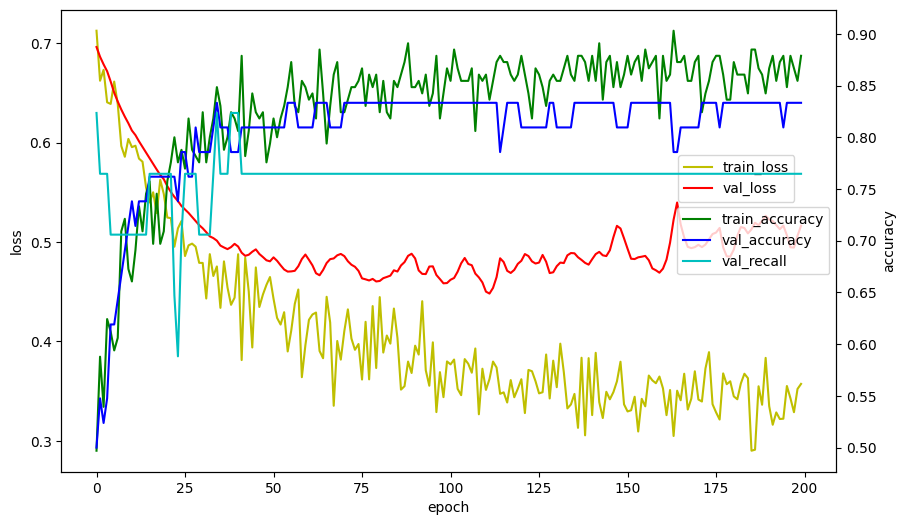

In [22]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
acc_ax.plot(hist.history['val_recall'], 'c', label='val_recall')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [23]:
score = model.evaluate(x_test, y_test, verbose=0)
print('model loss :', score[0])
print('model accuracy :', score[1])
print('model precision :', score[2])
print('model recall :', score[3])

model loss : 0.5643961429595947
model accuracy : 0.7977527976036072
model precision : 0.7804877758026123
model recall : 0.7804877758026123


In [24]:
# 교차표(혼동행렬)

In [25]:
y_hat = (model.predict(x_test) > 0.5).astype(int)
y_test.shape, y_hat.shape 

3/3 [==============================] - 0s 1ms/step


((89, 1), (89, 1))

In [26]:
y_hat.reshape(-1).shape

(89,)

In [27]:
TN=0; FP=0; FN=0; TP=0;
for y, h in zip(y_test, y_hat.reshape(-1)):
    # print(y, h)
    if y==0 and h==0:
        TN += 1  # TN갯수 하나 증가
    elif y==0 and h==1:
        FP += 1
    elif y==1 and h==0:
        FN += 1
    else:
        TP += 1
print(TN, FP)
print(FN, TP)

39 9
9 32


In [28]:
print(y_test.shape)
print(y_hat.shape)

(89, 1)
(89, 1)


In [31]:
ctab = pd.crosstab(y_test, y_hat.reshape(-1)) # y_hat에러남
ctab.index.name = '실제값'
ctab.columns.name = '예측값'
ctab

# pd.crosstab(y_test, # 실제값
#            y_hat.reshape(-1), # 예측값
#            rownames=['실제값'], # index이름
#            colnames=['예측값']) # column이름  : 결과가 데이터 프레임인 교차표

ValueError: All arrays must be of the same length

In [32]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_hat) 

array([[39,  9],
       [ 9, 32]], dtype=int64)

In [33]:
# 모델 사용

In [34]:
y_test[0]

array([1], dtype=int64)

In [35]:
from tensorflow.keras.models import save_model, load_model
model.save('model/heartDisease.h5')
save_model(model, 'model/heartDisease.h5')

In [36]:
model3 = load_model('model/heartDisease.h5')

In [37]:
(model3.predict([[ 62. ,   0. ,   4. , 140. , 268. ,   0. ,   2. , 160. ,   0. ,
         3.6,   3. ,   2. ,   3. ]])>0.5 ).astype(int)

1/1 [==============================] - 0s 60ms/step


array([[0]])

In [38]:
from tensorflow.keras.models import save_model, load_model

## 분류분석
- 데이터셋 생성 & 전처리
- x_train, y_train, x_test, y_test를 사용 -> y_train과 y_test 원핫인코딩
- 모델생성 & 학습과정 설정 & 학습
- 모델평가(그래프, 평가, 교차표)
- 모델 사용(저장, 예측)

### 데이터셋 생성 및 전처리

In [39]:
df = pd.read_excel('data/heart-disease.xlsx', header=None)
dataset = df.values
dataset

array([['age', 'sex', 'cp', ..., 'ca', 'hsl', 'heartDisease'],
       [63, 1, 1, ..., 0, 6, 0],
       [67, 1, 4, ..., 3, 3, 1],
       ...,
       [57, 1, 4, ..., 1, 7, 1],
       [57, 0, 2, ..., 1, 3, 1],
       [38, 1, 3, ..., '?', 3, 0]], dtype=object)

In [40]:
# 훈련셋600, 검증셋100, 테스트셋68
X_train = dataset[:600, :-1]
y_train = dataset[:600, -1]
X_val   = dataset[600:700, :-1]
y_val   = dataset[600:700, -1]
X_test  = dataset[700:, :-1]
y_test  = dataset[700:, -1]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((304, 13), (304,), (0, 13), (0,), (0, 13), (0,))

In [41]:
# 분류분석을 위한 타겟(종속)변수의 원핫인코딩
Y_train = utils.to_categorical(y_train)
Y_val   = utils.to_categorical(y_val, 2)
Y_test  = utils.to_categorical(y_test)
Y_train.shape, Y_val.shape, Y_test.shape

NameError: name 'utils' is not defined

### 모델생성(input8, target2

In [42]:
model = Sequential()
model.add(Dense(units=32, input_shape=(8,), activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=2, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                288       
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dense_6 (Dense)             (None, 2)                 34        
                                                                 
Total params: 850
Trainable params: 850
Non-trainable params: 0
_________________________________________________________________


### 학습과정 설정

In [44]:
model.compile(loss='categorical_crossentropy', 
              optimizer='nadam', 
              metrics=['accuracy'])

### 모델 학습

In [47]:
hist = model.fit(X_train, y_train,
                epochs=200,
                validation_data=(X_val, y_val),
                verbose=1)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

### 모델 평가

### 모델 사용하기